In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === 1. Importy ===
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib


In [ ]:
import nltk
from nltk.corpus import stopwords

try:
    _ = stopwords.words('english')  # or 'polish', etc.
except LookupError:
    nltk.download('stopwords')
    _ = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# === 2. Wczytanie danych ===
# Podaj własną ścieżkę do pliku CSV z kolumnami "text" i "target"
csv_path ='/content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/cnn/data_final_min30.csv'

df = pd.read_csv(csv_path)
print(df.head())

# sprawdź czy masz kolumny text / target
assert "text" in df.columns and "target" in df.columns

                                                text                  target
0  In December 2015, when fishermen took their bo...            3-d graphics
1  HYDERABAD: Students of the International Insti...            3-d graphics
2  <div class="section1"><div class="Normal">Fran...            3-d graphics
3  VISAKHAPATNAM: Officially, they may be called ...  adoption and fostering
4   NAGPUR: Keeping pace with the ecofriendly mov...         adult education


In [ ]:
df.head()

,text,target
0,"In December 2015, when fishermen took their bo...",3-d graphics
1,HYDERABAD: Students of the International Insti...,3-d graphics
2,"<div class=""section1""><div class=""Normal"">Fran...",3-d graphics
3,"VISAKHAPATNAM: Officially, they may be called ...",adoption and fostering
4,NAGPUR: Keeping pace with the ecofriendly mov...,adult education


In [ ]:
# === 3. Podział na train/test ===
X = df["text"].astype(str).fillna("")
y = df["target"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")


Train: 116332, Test: 29083


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk



In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')     # <-- new in recent NLTK versions
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_doc(text: str) -> str:
    # keep it simple; if you want POS-aware lemmatization, see note below
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
'''
pipe = Pipeline([
    ("lemmatize", FunctionTransformer(
        lambda docs: [lemmatize_doc(d) for d in docs], validate=False
    )),
    ("vect", CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        lowercase=True,
        stop_words='english'
    )),
    ("clf", MultinomialNB(alpha=1.0))
])

pipe.fit(X_train, y_train)
'''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


'\npipe = Pipeline([\n    ("lemmatize", FunctionTransformer(\n        lambda docs: [lemmatize_doc(d) for d in docs], validate=False\n    )),\n    ("vect", CountVectorizer(\n        ngram_range=(1, 2),\n        min_df=2,\n        lowercase=True,\n        stop_words=\'english\'\n    )),\n    ("clf", MultinomialNB(alpha=1.0))\n])\n\npipe.fit(X_train, y_train)\n'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet


def _ensure_nltk_data():
    required = [
        ("tokenizers/punkt", "punkt"),
        # Try both tagger package names for compatibility across NLTK versions
        ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
        ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
        ("corpora/wordnet", "wordnet"),
        ("corpora/omw-1.4", "omw-1.4"),
    ]
    for path, pkg in required:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk.download(pkg)

_ensure_nltk_data()

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def wn_pos(t):
    return {'J': wordnet.ADJ,'V': wordnet.VERB,'N': wordnet.NOUN,'R': wordnet.ADV}.get(t[0], wordnet.NOUN)

def lemmatize_doc(text):
    toks = word_tokenize(text)
    tagged = pos_tag(toks)
    return " ".join(lemmatizer.lemmatize(w, wn_pos(p)) for w,p in tagged)

def stem_doc(text):
    return " ".join(stemmer.stem(w) for w in word_tokenize(text))

from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight='balanced', y=y_train)


setups = {
  "tfidf_baseline": Pipeline([
        ("vect", TfidfVectorizer(ngram_range=(1,2), min_df=2, lowercase=True, stop_words='english')),
        ("clf", MultinomialNB(alpha=0.5))
    ]),

  # "lemmatie_then_bow": Pipeline([
  #       ("prep", FunctionTransformer(lambda X: [lemmatize_doc(t) for t in X], validate=False)),
  #       ("vect", CountVectorizer(ngram_range=(1,2), min_df=2, lowercase=True, stop_words='english')),
  #       ("clf", MultinomialNB(alpha=0.5))
  #   ]),

  #   "bow_baseline": Pipeline([
  #       ("vect", CountVectorizer(ngram_range=(1,2), min_df=2, lowercase=True, stop_words='english')),
  #       ("clf", MultinomialNB(alpha=0.5))
  #   ]),
  #   "stem_then_bow": Pipeline([
  #       ("prep", FunctionTransformer(lambda X: [stem_doc(t) for t in X], validate=False)),
  #       ("vect", CountVectorizer(ngram_range=(1,2), stop_words=None)),
  #       ("clf", MultinomialNB(alpha=0.5))
  #   ]),
}

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    top_k_accuracy_score,
    confusion_matrix,
    classification_report,
)

# --------- 1) ewaluacja  ---------
results = {}
topk_cols = {}  # zapamiętamy faktyczne "k" dla każdego modelu

for name, pipe in setups.items():
    # trening
    pipe.fit(X_train, y_train, clf__sample_weight=weights)

    # predykcje
    y_pred = pipe.predict(X_test)

    # metryki podstawowe
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # top-k accuracy
    k = min(5, len(getattr(pipe, "classes_", [])))
    topk = np.nan
    try:
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
            topk = top_k_accuracy_score(y_test, y_proba, labels=pipe.classes_, k=k)
        elif hasattr(pipe, "decision_function"):
            scores = pipe.decision_function(X_test)
            if scores.ndim == 1:
                scores = np.column_stack([-scores, scores])  # binarny przypadek
            topk = top_k_accuracy_score(y_test, scores, labels=pipe.classes_, k=k)
    except Exception:
        pass  # zostawiamy NaN, jeśli się nie dało policzyć

    results[name] = {
        "accuracy": acc,
        "f1_macro": f1m,
        "balanced_accuracy": bal_acc,
        "matthews_corrcoef": mcc,
        f"top{k}_accuracy": topk,
    }
    topk_cols[name] = f"top{k}_accuracy"

In [ ]:
print(results)

{'tfidf_baseline': {'accuracy': 0.7657050510607571, 'f1_macro': 0.7814179642927438, 'balanced_accuracy': np.float64(0.7910534363505101), 'matthews_corrcoef': np.float64(0.765229941163086), 'top5_accuracy': np.float64(0.9368359522745247)}}


In [ ]:
# budowa DataFrame + wyrównanie kolumn top-k
df_results = pd.DataFrame(results).T
# brakujące kolumny top-k uzupełniamy (gdy różne modele mają różne k)
all_topk_cols = sorted({c for c in df_results.columns if c.startswith("top")})
for c in all_topk_cols:
    if c not in df_results.columns:
        df_results[c] = np.nan

# sortowanie po f1_macro
df_results = df_results.sort_values("f1_macro", ascending=False)

# --------- 2) zapis do plików ---------
csv_path = "cv_free_results.csv"
xlsx_path = "cv_free_results.xlsx"
import os

# If file exists, append without header
if os.path.exists(csv_path):
    df_results.to_csv(csv_path, mode='a', header=False, index=True)
else:
    df_results.to_csv(csv_path, mode='w', header=True, index=True)



print("Zapisano wyniki:")
print(f"- CSV : {csv_path}")
print("\nTabela wyników (zaokrąglona):")
print(df_results.round(4))

# --------- 3) wybór najlepszego modelu i confusion matrix ---------
best_model_name = df_results.index[0]
best_pipe = setups[best_model_name]

print(f"\nNajlepszy model po f1_macro: {best_model_name}")

# retraining na całym train (żeby mieć świeży egzemplarz)
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)
classes = best_pipe.classes_

# raport tekstowy (opcjonalnie)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred_best, digits=4))

# macierze
cm_raw = confusion_matrix(y_test, y_pred_best, labels=classes)
cm_norm = confusion_matrix(y_test, y_pred_best, labels=classes, normalize="true") * 100

# zapis do CSV
cm_raw_df = pd.DataFrame(cm_raw, index=classes, columns=classes)
cm_norm_df = pd.DataFrame(cm_norm, index=classes, columns=classes)

cm_raw_csv = f"confusion_matrix_counts_{best_model_name}.csv"
cm_norm_csv = f"confusion_matrix_percent_{best_model_name}.csv"

cm_raw_df.to_csv(cm_raw_csv)
cm_norm_df.to_csv(cm_norm_csv)

print("Zapisano confusion matrix do CSV:")
print(f"- {cm_raw_csv} (liczności)")
print(f"- {cm_norm_csv} (procenty, wiersze sumują się do 100%)")

report_dict = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_csv = f"classification_report_{best_model_name}.csv"
report_df.to_csv(report_csv, index=True)

print("Saved classification report to:", report_csv)

Zapisano wyniki:
- CSV : cv_free_results.csv

Tabela wyników (zaokrąglona):
                accuracy  f1_macro  balanced_accuracy  matthews_corrcoef  \
tfidf_baseline    0.7657    0.7814             0.7911             0.7652   

                top5_accuracy  
tfidf_baseline         0.9368  

Najlepszy model po f1_macro: tfidf_baseline

Classification report (test):


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                precision    recall  f1-score   support

                                  3-d graphics     0.7031    0.7627    0.7317        59
                        adoption and fostering     0.9153    0.9000    0.9076        60
                               adult education     0.8571    0.7164    0.7805        67
                              adventure travel     0.8667    0.4727    0.6118        55
                                 africa travel     0.8308    0.9000    0.8640        60
                                   agriculture     0.8276    0.3934    0.5333        61
                                    air travel     1.0000    0.6885    0.8155        61
                           alcoholic beverages     0.8462    0.8209    0.8333        67
                                     allergies     0.8684    0.6226    0.7253        53
                             alternative music     1.0000    0.5294    0.6923        51
                              a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# === 4. Zapis modelu do pliku ===
# Zapis najlepszego modelu do pliku
model_filename = f"/content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/nb/mnb_best_model_{best_model_name}.pkl"
joblib.dump(best_pipe, model_filename)

print(f"Zapisano najlepszy model do pliku: {model_filename}")

Zapisano najlepszy model do pliku: /content/drive/MyDrive/Praca dyplomowa DataScience/wyniki/nb/mnb_best_model_tfidf_baseline.pkl


In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

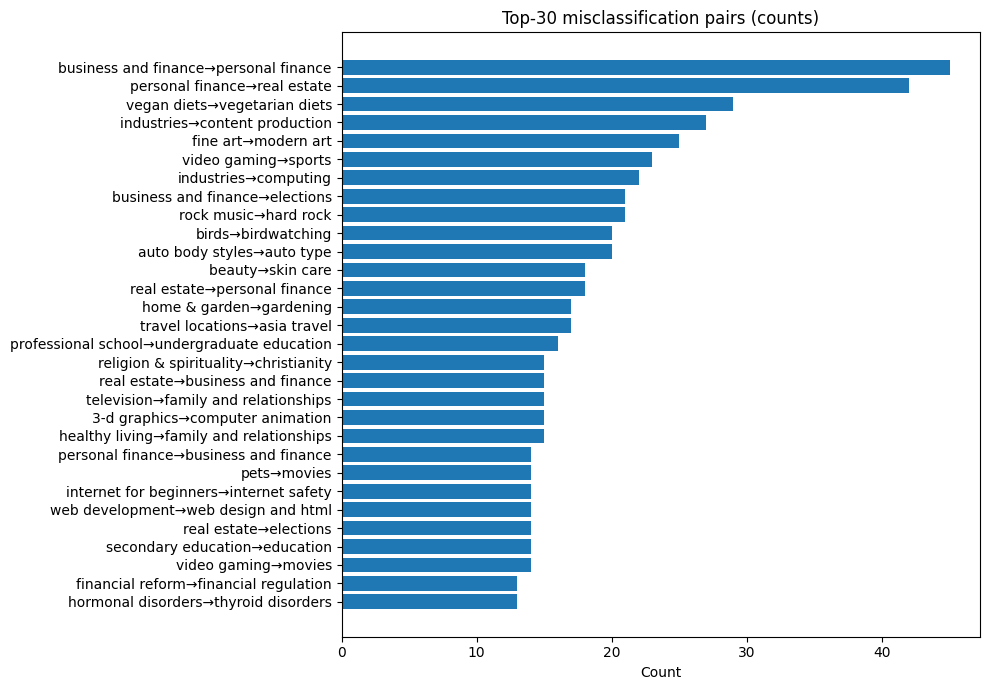

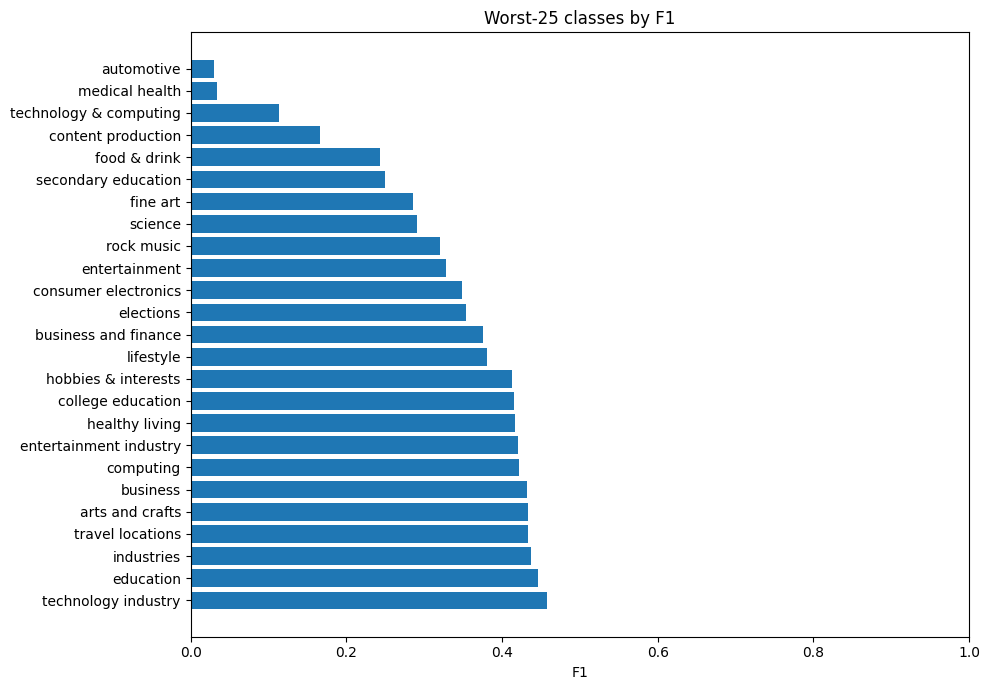

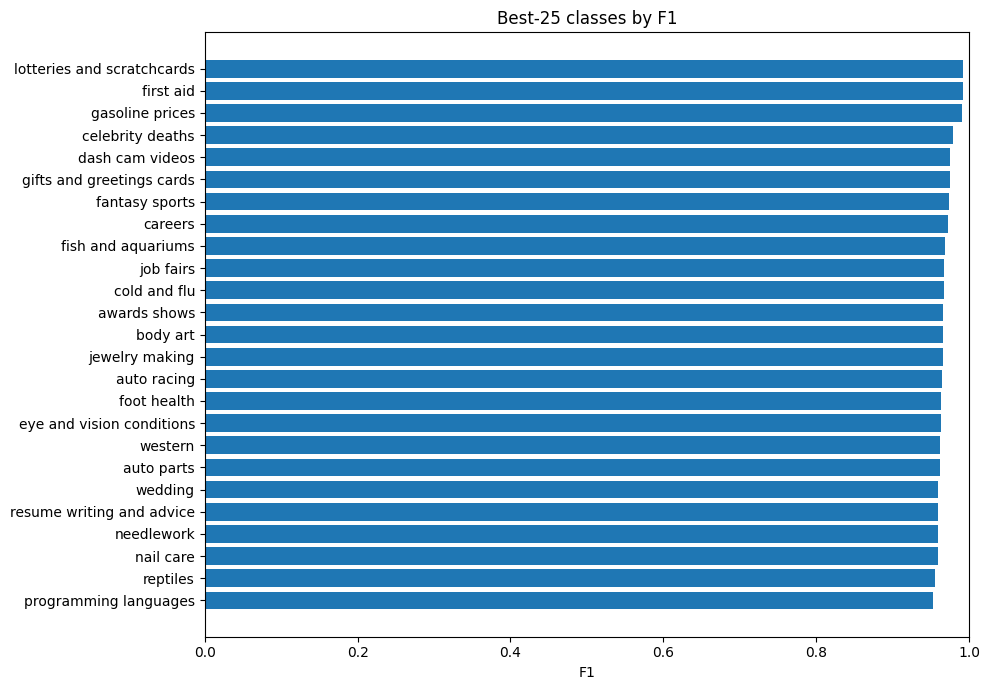

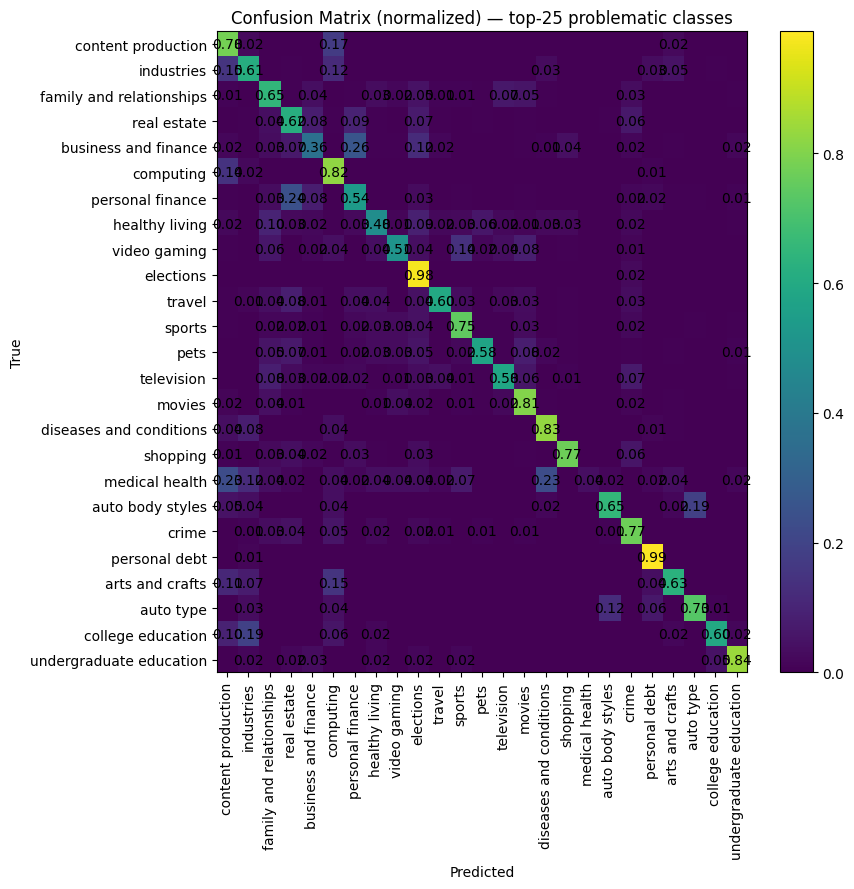

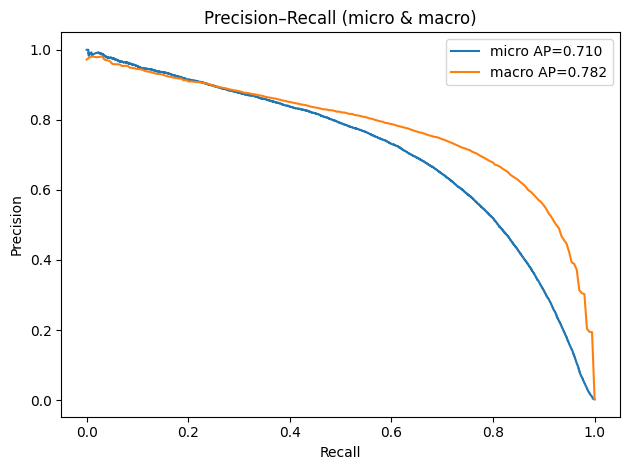

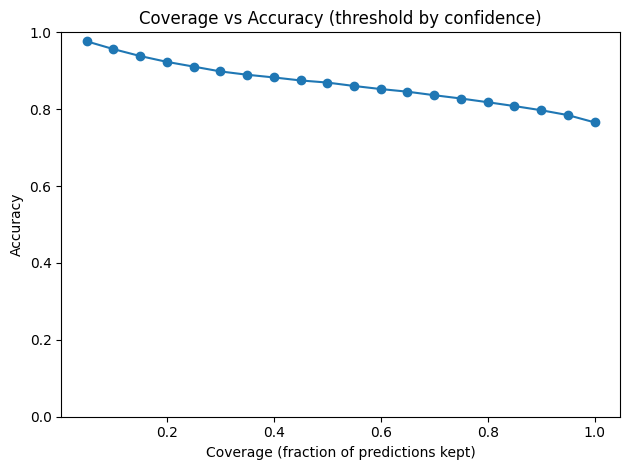

,class,precision,recall,f1,support
0,automotive,1.000000,0.015152,0.029851,66
1,medical health,1.000000,0.017391,0.034188,115
2,technology & computing,0.833333,0.060976,0.113636,82
3,content production,0.093294,0.780488,0.166667,41
4,food & drink,0.818182,0.142857,0.243243,63
5,secondary education,0.448276,0.173333,0.250000,75
6,fine art,0.866667,0.171053,0.285714,76
7,science,0.533333,0.200000,0.290909,40
8,rock music,0.481481,0.240741,0.320988,54
9,entertainment,0.950000,0.197917,0.327586,96


,true,pred,count
516,business and finance,personal finance,45
2406,personal finance,real estate,42
3205,vegan diets,vegetarian diets,29
1743,industries,content production,27
1293,fine art,modern art,25
3245,video gaming,sports,23
1742,industries,computing,22
505,business and finance,elections,21
2691,rock music,hard rock,21
382,birds,birdwatching,20


CSV exports:
- Per-class metrics: per_class_metricstfidf_baseline.csv
- Misclassification pairs: top_misclass_pairstfidf_baseline.csv


In [ ]:
classes_sorted = list(pipe.classes_)
n_classes = len(classes_sorted)
# -------------------------
# Per-class metrics table
# -------------------------
report = classification_report(y_test, y_pred, labels=classes_sorted, output_dict=True, zero_division=0)
rows = []
for c in classes_sorted:
    d = report[c]
    rows.append({
        "class": c,
        "precision": d["precision"],
        "recall": d["recall"],
        "f1": d["f1-score"],
        "support": int(d["support"])
    })
metrics_df = pd.DataFrame(rows).sort_values("f1", ascending=True).reset_index(drop=True)

# Export CSVs
metrics_path = f"per_class_metrics{best_model_name}.csv"
metrics_df.to_csv(metrics_path, index=False)

# -------------------------
# 1) Top-N misclassification pairs
# -------------------------
cm_counts = confusion_matrix(y_test, y_pred, labels=classes_sorted)  # raw counts
cm_no_diag = cm_counts.copy()
np.fill_diagonal(cm_no_diag, 0)
pairs = []
for i_true, true_c in enumerate(classes_sorted):
    for j_pred, pred_c in enumerate(classes_sorted):
        count = cm_no_diag[i_true, j_pred]
        if count > 0:
            pairs.append((true_c, pred_c, int(count)))
pairs_df = pd.DataFrame(pairs, columns=["true","pred","count"]).sort_values("count", ascending=False)

TOP_N_PAIRS = 30
pairs_top = pairs_df.head(TOP_N_PAIRS).copy()
pairs_path = f"top_misclass_pairs{best_model_name}.csv"
pairs_df.to_csv(pairs_path, index=False)

# Plot
fig = plt.figure(figsize=(10, 7))
labels_bar = [f"{t}→{p}" for t,p,_ in pairs_top.values]
plt.barh(np.arange(len(pairs_top)), pairs_top["count"].values)
plt.yticks(np.arange(len(pairs_top)), labels_bar)
plt.gca().invert_yaxis()
plt.title(f"Top-{TOP_N_PAIRS} misclassification pairs (counts)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# -------------------------
# 2) Per-class F1 sorted (worst K and best K)
# -------------------------
K = 25  # how many to show
worst_k = metrics_df.head(K)
best_k = metrics_df.tail(K).sort_values("f1", ascending=False)

# Worst-K
fig = plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(worst_k)), worst_k["f1"].values)
plt.yticks(np.arange(len(worst_k)), worst_k["class"].values)
plt.gca().invert_yaxis()
plt.title(f"Worst-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

# Best-K
fig = plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(best_k)), best_k["f1"].values)
plt.yticks(np.arange(len(best_k)), best_k["class"].values)
plt.gca().invert_yaxis()
plt.title(f"Best-{K} classes by F1")
plt.xlabel("F1")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

# -------------------------
# 3) Confusion matrix for K key classes
# Strategy: pick K classes with the largest (false negatives + false positives)
# i.e., the most "problematic" classes; fall back to top by support if ties.
# -------------------------
errors_per_class = cm_no_diag.sum(axis=1) + cm_no_diag.sum(axis=0)
support_per_class = cm_counts.sum(axis=1)
key_idx = np.argsort(errors_per_class)[::-1][:K]
key_classes = [classes_sorted[i] for i in key_idx]

# Sub-matrix
cm_sub = confusion_matrix(y_test, y_pred, labels=key_classes)
cm_sub_norm = cm_sub.astype(float) / cm_sub.sum(axis=1, keepdims=True)
cm_sub_norm = np.nan_to_num(cm_sub_norm)

fig = plt.figure(figsize=(9, 9))
plt.imshow(cm_sub_norm, interpolation='nearest', aspect='auto')
plt.title(f"Confusion Matrix (normalized) — top-{K} problematic classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(key_classes)), key_classes, rotation=90)
plt.yticks(np.arange(len(key_classes)), key_classes)
for i in range(cm_sub_norm.shape[0]):
    for j in range(cm_sub_norm.shape[1]):
        val = cm_sub_norm[i, j]
        if val > 0.01:
            plt.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# -------------------------
# 4) Precision–Recall (micro & macro)
# -------------------------
from sklearn.preprocessing import label_binarize
y_true_idx = np.array([classes_sorted.index(y) for y in y_test])
Y = label_binarize(y_true_idx, classes=np.arange(n_classes))
probs = y_proba
prec_micro, rec_micro, _ = precision_recall_curve(Y.ravel(), probs.ravel())
ap_micro = average_precision_score(Y, probs, average="micro")

# Macro
precisions = []
recalls = []
ap_list = []
for i in range(n_classes):
    p_i, r_i, _ = precision_recall_curve(Y[:, i], probs[:, i])
    # Interpolate onto common grid for macro plot
    recalls.append(r_i[::-1])
    precisions.append(p_i[::-1])
    ap_list.append(average_precision_score(Y[:, i], probs[:, i]))
grid = np.linspace(0, 1, 200)
prec_interp = []
for r, p in zip(recalls, precisions):
    prec_interp.append(np.interp(grid, r, p, left=p[0], right=p[-1]))
prec_macro = np.mean(np.vstack(prec_interp), axis=0)
rec_macro = grid
ap_macro = float(np.mean(ap_list))

fig = plt.figure()
plt.plot(rec_micro, prec_micro, label=f"micro AP={ap_micro:.3f}")
plt.plot(rec_macro, prec_macro, label=f"macro AP={ap_macro:.3f}")
plt.title("Precision–Recall (micro & macro)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 5) Coverage vs Accuracy curve
# Sort predictions by max probability; show accuracy @ coverage
# -------------------------
max_prob = probs.max(axis=1)
correct = (y_pred == np.array(y_test))
order = np.argsort(-max_prob)
sorted_correct = correct[order]

covers = np.linspace(0.05, 1.0, 20)
acc_at_cov = []
n = len(sorted_correct)
for c in covers:
    k = int(np.ceil(c * n))
    acc_at_cov.append(sorted_correct[:k].mean())

fig = plt.figure()
plt.plot(covers, acc_at_cov, marker="o")
plt.title("Coverage vs Accuracy (threshold by confidence)")
plt.xlabel("Coverage (fraction of predictions kept)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# -------------------------
# Show dataframes to user for filtering/sorting
# -------------------------
# po prostu wyświetlić dataframe
display(metrics_df.head(20))   # np. 20 najgorszych klas
display(pairs_df.head(20))

print("CSV exports:")
print(f"- Per-class metrics: {metrics_path}")
print(f"- Misclassification pairs: {pairs_path}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
pipeline = pipe
# scorer dla log-loss (trzeba ustawić "greater_is_better=False", bo mniejszy=lepszy)
logloss_scorer = make_scorer(log_loss, needs_proba=True, greater_is_better=False, labels=pipeline.classes_)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring=logloss_scorer,
    n_jobs=1,
    shuffle=True,
    random_state=42
)

# ponieważ scorer zwraca wartości ujemne (bo greater_is_better=False),
# odwracamy znak, żeby mieć faktyczny log-loss
train_losses = -train_scores.mean(axis=1)
test_losses  = -test_scores.mean(axis=1)

# wykres
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_losses, marker="o", label="Train log-loss")
plt.plot(train_sizes, test_losses, marker="o", label="Validation log-loss")
plt.xlabel("Training set size")
plt.ylabel("Log-loss (cross-entropy)")
plt.title("Learning curve (log-loss)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us

KeyboardInterrupt: 